# Visão geral dos dados coletados

## Imports

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

import sys


sys.path.append("../../")
sys.path.append("../../odbc")
import query_tools as qt
from connection import load_conn

## Linhas coletadas

### Quantas linhas de informação dos voos foram coletadas?

In [3]:
q = """
SELECT count(*)
FROM flight.search
"""
qt.run_query(q)

,count
0,212790744


In [4]:
q = """
SELECT count(*)
FROM flight.fare
"""
qt.run_query(q)

,count
0,212790744


In [5]:
q = """
SELECT count(*)
FROM flight.flight
"""
qt.run_query(q)

,count
0,212790744


### Em média quantas linhas novas são coletadas por dia?
Obs: considerando que o crawler coletaria 24h por dia
Uma boa estimativa é verificar qual a média de linhas coletadas por hora e multiplicar por 24h, vai ser uma estimativa melhor.

In [6]:
# Media e desvio padrao do nº de linhas coletadas por hora
q = """
SELECT AVG(count) AS average_rows_por_hora, stddev(count) AS desvio_padrao_por_hora
FROM (
    SELECT COUNT(*) AS count
    FROM flight.search
    GROUP BY DATE_TRUNC('hour', "operationalSearchTime")
) subquery
"""
metricas_coleta_linhas_por_hora = qt.run_query(q)
metricas_coleta_linhas_por_hora

,average_rows_por_hora,desvio_padrao_por_hora
0,203627.50622,68098.20605


In [7]:
estimativa_linhas_coletadas_por_dia = metricas_coleta_linhas_por_hora.loc[0, "average_rows_por_hora"] * 24
estimativa_linhas_coletadas_por_dia

4887060.149282297

## Memória

### Quantos Bytes tem o banco de dados?

In [8]:
# Consulta para obter o tamanho do banco de dados em bytes
q = "SELECT pg_database_size('flight')"
bytes_df = qt.run_query(q)
bytes_df

,pg_database_size
0,172203664163


### Quantos Gigabytes tem o banco de dados?

In [9]:
bytes_ = bytes_df.loc[0, "pg_database_size"]
# Consulta para obter o tamanho do banco de dados em gigabytes 
q = f"SELECT pg_size_pretty({bytes_})"
qt.run_query(q)

,pg_size_pretty
0,160 GB


## Coleta de dados

### Quais as datas e horários que temos coletados?

In [10]:
q = """
SELECT DISTINCT DATE_TRUNC('hour', "operationalSearchTime") AS "operationalSearchTime"
FROM flight.search
"""

operationalSearchTime = qt.run_query(q)

In [11]:
operationalSearchTime.head(1)

,operationalSearchTime
0,2023-06-04 09:00:00


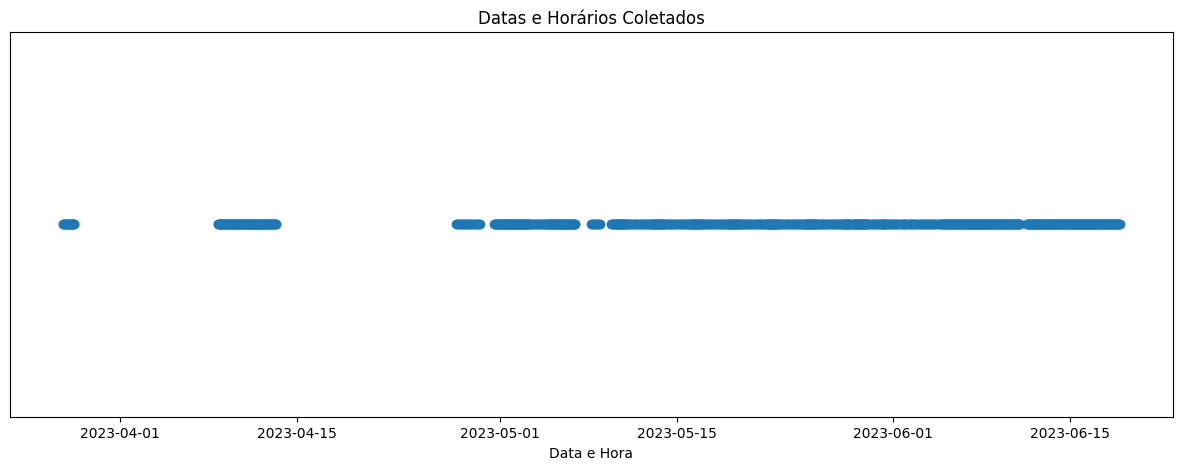

In [12]:
plt.figure(figsize=(15, 5))
plt.scatter(operationalSearchTime['operationalSearchTime'],
            [1] * len(operationalSearchTime))
plt.yticks([])  # Remove os valores no eixo y
plt.xlabel('Data e Hora')
plt.title('Datas e Horários Coletados')
plt.show()


### Qual a quantidade de voos capturados em cada coleta?

In [13]:
q = """
SELECT DISTINCT DATE_TRUNC('hour', "operationalSearchTime") AS hora_coletada,
    count(*) AS linhas_coletadas
FROM flight.search
GROUP BY hora_coletada
"""
coleta = qt.run_query(q)

In [14]:
coleta.hora_coletada.max(), coleta.hora_coletada.min()

(Timestamp('2023-06-18 22:00:00'), Timestamp('2023-03-27 12:00:00'))

In [16]:
# Definir intervalo de datas completo
start_date = coleta['hora_coletada'].min()
end_date = coleta['hora_coletada'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Criar DataFrame com todas as horas do intervalo
complete_df = pd.DataFrame({'hora_coletada': date_range})

# Fazer merge dos DataFrames
coleta_completa = pd.merge(complete_df, coleta, on='hora_coletada', how='left')
coleta_completa['linhas_coletadas'] = coleta_completa['linhas_coletadas'].fillna(0)

# Ordenar DataFrame pelo horário
coleta_completa = coleta_completa.sort_values('hora_coletada')


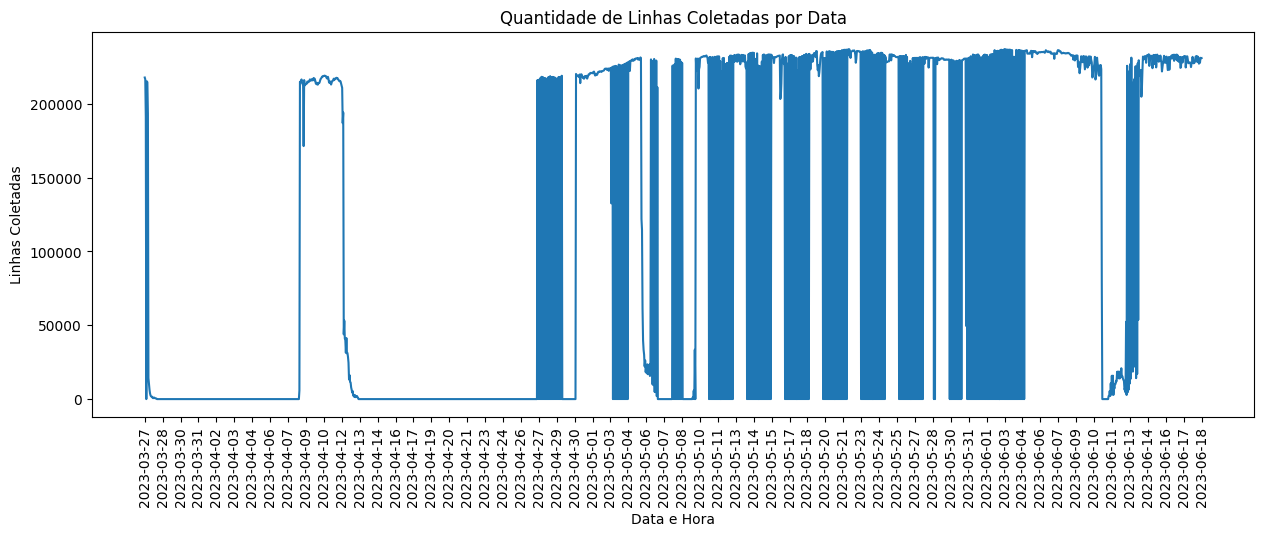

In [17]:
# Criando o gráfico
plt.figure(figsize=(15, 5))
plt.plot(coleta_completa["hora_coletada"], coleta_completa["linhas_coletadas"])
plt.xticks(rotation=90)

# Configurando as datas no eixo x
num_ticks = 60  # Número desejado de ticks no eixo x
date_range = pd.date_range(start=coleta_completa["hora_coletada"].min(),
                           end=coleta_completa["hora_coletada"].max(),
                           periods=num_ticks)
plt.xticks(date_range, rotation=90)

plt.xlabel('Data e Hora')
plt.ylabel('Linhas Coletadas')
plt.title('Quantidade de Linhas Coletadas por Data')
plt.show()


### Qual a maior janela de coleta consecutiva?

In [27]:
coleta_completa.sort_values("hora_coletada", inplace=True, ignore_index=True)
display(coleta_completa.head())


limiar = 180_000
teve_coleta = (coleta_completa.linhas_coletadas >= limiar).map(int)

,hora_coletada,linhas_coletadas
0,2023-03-27 12:00:00,217728.0
1,2023-03-27 13:00:00,216485.0
2,2023-03-27 14:00:00,191034.0
3,2023-03-27 15:00:00,0.0
4,2023-03-27 16:00:00,215153.0


In [29]:
# Variáveis para acompanhar a sequência atual e a sequência máxima
numero_zeros_aceitaveis = 0
current_sequence = 0
max_sequence = 0
primeiro_valor_sequencia = True
menor_data = None
maior_data = None

contador_zeros = 0

# Percorrer a série
for indice, value in enumerate(teve_coleta):
    if value == 1:
        if primeiro_valor_sequencia:
            menor_data_sequencia_atual = coleta_completa.loc[indice, "hora_coletada"]
            primeiro_valor_sequencia = False

        current_sequence += 1
        contador_zeros = 0
        if current_sequence > max_sequence:
            max_sequence = current_sequence
            menor_data = menor_data_sequencia_atual
            maior_data = coleta_completa.loc[indice, "hora_coletada"]
    else:
        contador_zeros += 1
        
        if contador_zeros > numero_zeros_aceitaveis:
            current_sequence = 0
            primeiro_valor_sequencia = True

print("Maior sequência de 1's:", max_sequence, f"Isso equivale a {round(max_sequence / 24, 2)} dias")
print(f"Data de inicio da sequencia {menor_data} , data do fim da sequencia {maior_data}")

Maior sequência de 1's: 146 Isso equivale a 6.08 dias
Data de inicio da sequencia 2023-06-04 23:00:00 , data do fim da sequencia 2023-06-11 00:00:00


In [30]:
# Conferindo o intervalo encontrado
numero_horas = len(pd.date_range(start=menor_data, end=maior_data, freq='H'))
numero_horas, numero_horas/24

(146, 6.083333333333333)

## Voos únicos

### Quantos voos únicos foram coletados?

In [3]:
from time import time

In [17]:
time1 = time()
q = """
SELECT count(*) as voos_unicos
FROM (SELECT DISTINCT "legId" FROM flight.fare) subquery
"""
resultado = qt.run_query(q)
time2 = time()
resultado

,voos_unicos
0,1288076


In [18]:
time2 - time1

117.61396551132202

In [19]:
time3 = time()
q = """
SELECT count(DISTINCT "legId") as voos_unicos
FROM flight.fare
"""
qt.run_query(q)
time4 = time()

In [20]:
time4 - time3

1339.7891097068787

### Em média quantos voos únicos são coletados por dia?


In [21]:
# q = """
# SELECT AVG(voos_unicos) as media_voos_unicos
# FROM (
#     SELECT DATE_TRUNC('day', "operationalSearchTime") as search_day,
#         count(*) AS voos_unicos
#     FROM (SELECT DISTINCT F."legId", S."operationalSearchTime"
#           FROM flight.fare F
#           JOIN flight.search S ON F."searchId" = S."searchId"
#           ) subquery
#     GROUP BY search_day
# ) subquery2
# """

# media_voos_unicos_dia = qt.run_query(q)
# media_voos_unicos_dia

In [22]:
# q = """
# SELECT DATE_TRUNC('day', S."operationalSearchTime") as day, count(distinct F."legId")

# FROM  flight.fare F
#       JOIN flight.search S
#       ON F."searchId" = S."searchId"

# GROUP BY DATE_TRUNC('day', S."operationalSearchTime")
# LIMIT 100
# """

# media_voos_unicos_dia = qt.run_query(q)
# media_voos_unicos_dia

In [ ]:
# media_voos_unicos_dia["media_voos_unicos"] = media_voos_unicos_dia["media_voos_unicos"].apply(lambda x: '{:,.2f}'.format(x))
# media_voos_unicos_dia
# TEM ALGO MUITO ESTRANHO AQUI, VERIFICAR ISSO

## Cidade

In [28]:
airport = qt.get_table("airport")
airport = airport[["airportCode", "city"]]

def merge_airport(df, column_merge):
    if isinstance(column_merge, str):
        df = df.merge(airport, how="left", left_on=column_merge, right_on="airportCode")
        del df["airportCode"]
    elif isinstance(column_merge, list):
        for index, column in enumerate(column_merge):
            old_column = "" if index == 0 else column_merge[(index-1)]
            df = df.merge(airport, how="left",
                          left_on=column,
                          right_on="airportCode",
                          suffixes=(old_column, f"_{column}"))
            del df["airportCode"]
    return df

### Quantos voos únicos saem de cada cidade?

In [ ]:
q = """
SELECT "originCode", count(*) as voos_unicos
FROM (
    SELECT DISTINCT "legId", "originCode"
    FROM flight.fare F
        JOIN flight.search S
        ON S."searchId" = F."searchId" 
) subquery
GROUP BY "originCode"
ORDER BY voos_unicos DESC
"""
voos_unicos_saida = qt.run_query(q)

In [47]:
voos_unicos_saida = merge_airport(voos_unicos_saida, "originCode")
voos_unicos_saida.groupby("city").sum().reset_index().sort_values("voos_unicos", ascending=False)

,city,voos_unicos
4,Rio de Janeiro,257902
6,São Paulo,198152
3,Porto Alegre,186599
5,Salvador,179083
2,Manaus,175318
1,Brasilia,154827
0,Belo Horizonte,136195


### Quantos voos únicos chegam em cada cidade?

In [ ]:
q = """
SELECT "destinationCode", count(*) as voos_unicos
FROM (
    SELECT DISTINCT "legId", "destinationCode"
    FROM flight.fare F
        JOIN flight.search S
        ON S."searchId" = F."searchId" 
) subquery
GROUP BY "destinationCode"
ORDER BY voos_unicos DESC
"""
voos_unicos_chegada = qt.run_query(q)

In [57]:
voos_unicos_chegada = merge_airport(voos_unicos_chegada, "destinationCode")

In [61]:
voos_unicos_chegada.groupby("city").sum().reset_index().sort_values("voos_unicos", ascending=False)

/tmp/ipykernel_1835415/200320251.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  voos_unicos_chegada.groupby("city").sum().reset_index().sort_values("voos_unicos", ascending=False)


,city,voos_unicos
4,Rio de Janeiro,239413
6,São Paulo,204014
3,Porto Alegre,188359
2,Manaus,181051
5,Salvador,176788
1,Brasilia,159588
0,Belo Horizonte,138863


### Quantos voos únicos existem em cada trecho?

In [ ]:
q = """
SELECT "originCode", "destinationCode", count(*) as voos_unicos
FROM (
    SELECT DISTINCT "legId", "originCode", "destinationCode"
    FROM flight.fare F
        JOIN flight.search S
        ON S."searchId" = F."searchId" 
) subquery
GROUP BY  "originCode", "destinationCode"
ORDER BY voos_unicos DESC
"""
voos_unicos_trecho = qt.run_query(q)

In [64]:
voos_unicos_trecho = merge_airport(voos_unicos_trecho, ["originCode", "destinationCode"])

In [53]:
(voos_unicos_trecho[["cityoriginCode", "city_destinationCode", "voos_unicos"]]
 .groupby(["cityoriginCode", "city_destinationCode"])
 .sum()
 .reset_index()
 .sort_values("voos_unicos", ascending=False))

,cityoriginCode,city_destinationCode,voos_unicos
27,Rio de Janeiro,Porto Alegre,48728
21,Porto Alegre,Rio de Janeiro,46309
29,Rio de Janeiro,São Paulo,46196
40,São Paulo,Rio de Janeiro,44707
28,Rio de Janeiro,Salvador,44091
26,Rio de Janeiro,Manaus,43846
25,Rio de Janeiro,Brasilia,42566
17,Manaus,São Paulo,42009
38,São Paulo,Manaus,41134
34,Salvador,Rio de Janeiro,40186


In [ ]:
# voos_unicos_trecho[["cityoriginCode", "city_destinationCode", "voos_unicos"]].head(50)

## Companias aéreas 

### Quais são as companhias aéreas coletadas?

In [23]:
qt.get_table("airline")[["airlineCode", "airlineName"]].drop_duplicates()

,airlineCode,airlineName
0,LA,LATAM Airlines Group
1,G3,GOL Linhas Aereas S.A.
6,H1,Hahn Air Systems


### Quantos voos únicos cada companía fez?

In [27]:
q = """
SELECT "airlineName", count(*) as voos_unicos
FROM (
    SELECT DISTINCT F."legId", A."airlineName"
    FROM flight.flight F
        LEFT JOIN flight.airline A
        ON A."airlineCode" = F."airlineCode"
) subquery
GROUP BY  "airlineName"
ORDER BY voos_unicos DESC
"""
voos_unicos_compania = qt.run_query(q)

In [26]:
voos_unicos_compania

,airlineName,voos_unicos
0,None,1212133
1,LATAM Airlines Group,40168
2,GOL Linhas Aereas S.A.,35775
